In [1]:
import numpy as np

from copy import deepcopy
import os
import struct

from matplotlib import pyplot
import matplotlib as mpl
%matplotlib inline

In [2]:
class Loss:
    
    def predict(self, h):
        pass
    
    def calculate_loss(self, h, target):
        pass

    
class SoftmaxLoss(Loss):

    def predict(self, h):
        return self.softmax(h)
    
    def softmax(self, h):
        hmax = np.expand_dims(np.max(h, axis=1),1)
        ex = np.exp(h - hmax) # normalize to avoid int overflow
        sm = ex / ex.sum(axis=1, keepdims=1)
        return sm

    def calculate_loss(self, h, target):
        rows = h.shape[0]
        probabilities = self.softmax(h)
        loss = np.sum(-np.log(probabilities[range(rows), target])) / rows
        dx = probabilities
        dx[range(rows), target] -= 1
        dx /= rows
        return (loss, dx)

In [3]:
class Layer:
    
    def forward_pass(self, x):
        pass
    
    def backward_pass(self, deriv):
        pass
    
    def update(self, dx, db):
        pass
    
    
class DenseLayer(Layer):

    def __init__(self, inputs, size):
        he_stdev = np.sqrt(2/inputs)
        self.w = np.random.normal(0, he_stdev, (inputs, size))
        self.b = np.zeros(size)

    def forward_pass(self, x):
        self.last_x = x
        out = np.dot(x, self.w) + self.b
        return out

    def backward_pass(self, deriv):
        x = self.last_x
        dx = np.dot(deriv, self.w.T)
        dw = np.dot(x.T, deriv)
        db = np.sum(deriv, axis=0, keepdims=True)
        return dx, dw, db
    
    def update(self, dw, db):
        self.w += dw
        self.b += db.flatten()

In [4]:
class ReluLayer(Layer):

    def forward_pass(self, x):
        self.last_x = x
        return np.maximum(0, x)

    def backward_pass(self, deriv):
        dx = deriv
        dx[self.last_x <= 0] = 0
        return (dx, 0, 0)

In [5]:
class Dropout(Layer):
    
    def __init__(self, keep_probability):
        self.keep_probability = keep_probability
    
    def forward_pass(self, x):
        if not self.train:
            return x
        self.w = np.random.binomial(1, self.keep_probability, x.shape) / self.keep_probability
        return x*self.w

    def backward_pass(self, deriv):
        return (deriv*self.w, 0, 0)

In [6]:
class Model:
    
    def __init__(self, loss, learning_rate = 1e-3):
        self.layers = []
        self.loss = loss
        self.learning_rate = learning_rate
        
    def add_layer(self, layer):
        self.layers.append(layer)
        
    def forward_pass(self, x, train=False):
        for l in self.layers:
            l.train = train
            x = l.forward_pass(x)
        return x
    
    def backward_pass(self, dy):
        for l in reversed(self.layers):
            dy, dw, db = l.backward_pass(dy)
            l.update(-self.learning_rate*dw, -self.learning_rate*db)
      
    def predict(self, x):
        logits = self.forward_pass(x)
        return self.loss.predict(logits)
    
    def train(self, x, target):
        h = self.forward_pass(x, train=True)
        loss_value, dy = self.loss.calculate_loss(h, target)
        self.backward_pass(dy)
        return loss_value

In [7]:
# mnist data load, derived from https://gist.github.com/akesling/5358964
def read(dataset = "training", path = "../data/mnist"):
    if dataset is "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')
    else:
        raise ValueError("dataset must be 'testing' or 'training'")

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)

    return img, lbl
        
def show(image):
    fig = pyplot.figure(figsize=(1,1))
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
    pyplot.show()

In [8]:
fashion_mnist_names = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

In [9]:
imgs, labels  = read()
timgs, tlabels  = read('testing')

In [10]:
def shuffle_arrays(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def train_val_split(a, b, val_size=0.1):
    assert len(a) == len(b)
    a, b = shuffle_arrays(a, b)
    border = int(len(a) * val_size)
    return a[border:], b[border:], a[:border], b[:border]

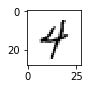

4


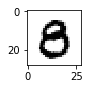

8


In [11]:
train_imgs, train_labels, val_imgs, val_labels = train_val_split(imgs, labels)
show(train_imgs[2])
print(train_labels[2])
show(val_imgs[555])
print(val_labels[555])

In [12]:
def test(test_model, imgs, labels):
    hits = 0
    errs = 0
    for i in range(len(imgs)):
        x = imgs[i].reshape(1,784)/255
        y = labels[i]
        h = np.argmax(test_model.predict(x), axis=1)
        if h[0]==y:
            hits += 1
        else:
            errs += 1
    acc = hits / (i + 1)
    return acc, errs

In [13]:
def eval_model(model, best_acc, best_model):
    val_acc, val_err = test(model, val_imgs, val_labels)
    if val_acc > best_acc:
        best_acc = val_acc
        best_model = deepcopy(model)
        print('New best val acc %.3f, %d errors' % (val_acc, val_err))
    return best_acc, best_model

Train on 54000 images
iter 0 loss 2.5496 acc 0.1484
iter 1000 loss 0.2514 acc 0.9688
iter 2000 loss 0.2408 acc 0.9609
New best val acc 0.961, 233 errors
iter 3000 loss 0.1514 acc 0.9688
iter 4000 loss 0.1701 acc 0.9766
iter 5000 loss 0.1868 acc 0.9688
iter 6000 loss 0.0987 acc 0.9688
New best val acc 0.974, 156 errors
iter 7000 loss 0.1994 acc 0.9844
New best val acc 0.976, 142 errors
iter 8000 loss 0.1483 acc 0.9609
New best val acc 0.977, 138 errors
New best val acc 0.978, 133 errors
iter 9000 loss 0.0435 acc 1.0000
iter 10000 loss 0.0515 acc 0.9844
iter 11000 loss 0.0525 acc 0.9844
New best val acc 0.979, 125 errors
New best val acc 0.980, 119 errors
iter 12000 loss 0.0661 acc 0.9922
iter 13000 loss 0.0573 acc 0.9922
iter 14000 loss 0.1043 acc 0.9844
New best val acc 0.981, 117 errors
iter 15000 loss 0.0431 acc 1.0000
New best val acc 0.981, 112 errors
iter 16000 loss 0.0512 acc 1.0000
New best val acc 0.983, 105 errors
iter 17000 loss 0.0566 acc 1.0000
iter 18000 loss 0.0761 acc 0.

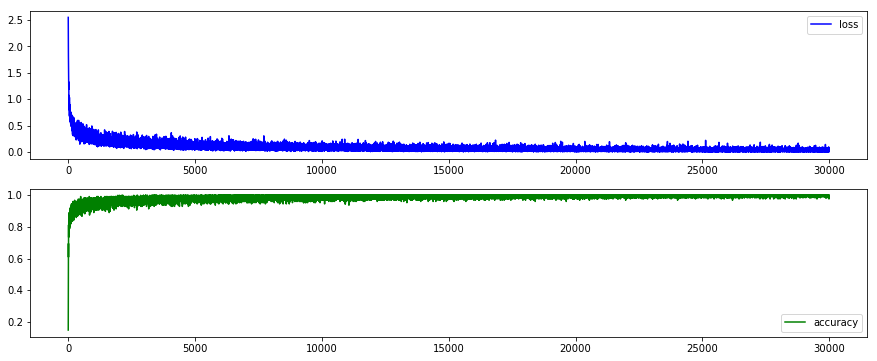

Test accuracy 0.982, 176 errors


In [14]:
losses = []
accuracies = []
batch_size = 128
iterated = 0
best_acc = 0
best_model = None
iterations = 30000

model = Model(SoftmaxLoss(), 0.1)
model.add_layer(DenseLayer(28 * 28, 300))
model.add_layer(ReluLayer())
model.add_layer(Dropout(0.5))
model.add_layer(DenseLayer(300, 10))

print("Train on %d images" % len(train_imgs))
for c in range(iterations):
    i = np.random.randint(0, len(train_imgs) - batch_size)
    iterated += batch_size
    x = train_imgs[i: i + batch_size].reshape(batch_size, 28 * 28) / 255
    y = train_labels[i: i + batch_size]
    
    loss = model.train(x, y)
    losses.append(loss)
    
    h = np.argmax(model.predict(x), axis=1)
    hits = np.count_nonzero(np.equal(h, y))
    acc = hits / batch_size
    accuracies.append(acc)

    if c % 500 == 0 and acc > 0.99:
        best_acc, best_model = eval_model(model, best_acc, best_model)
    if c % 1000 == 0:
        print('iter %d loss %.4f acc %.4f' % (c, loss, acc))

print('iter %d loss %.4f acc %.4f' % (c, loss, acc))
best_acc, best_model = eval_model(model, best_acc, best_model)

fig, ax = pyplot.subplots(2,1, figsize=(15, 6))
ax[0].plot(losses, color='b', label="loss")
ax[1].plot(accuracies, color='g', label="accuracy")
legend = ax[0].legend(loc='best')
legend = ax[1].legend(loc='best')
pyplot.show()
test_acc, test_err = test(best_model, timgs, tlabels)
print('Test accuracy %.3f, %d errors' % (test_acc, test_err))